#### **Data Preprocessing WF V2**

**Data Loading**

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import torch
import torch.nn.functional as F

from pathlib import Path
import os
from tqdm import tqdm


In [2]:
# check torch and cuda versions
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.9.0+cu129
CUDA available: True
Device name: NVIDIA GeForce RTX 5090 Laptop GPU


In [3]:
# define paths
csv_path = Path(r"D:\projects\research\HighResHippocampus_11_09_2025.csv")
nifti_root = Path(r"D:\projects\research\Converted_NIfTI")

# read metadata
mri_df = pd.read_csv(csv_path)
mri_df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I863061,002_S_0413,CN,F,87,init,MRI,HighResHippocampus,Original,6/21/2017,DCM,Yes
1,I843515,002_S_1155,MCI,M,68,init,MRI,HighResHippocampus,Original,4/24/2017,DCM,Yes
2,I831074,002_S_1261,CN,F,81,init,MRI,HighResHippocampus,Original,3/15/2017,DCM,Yes
3,I829301,002_S_1280,CN,F,81,init,MRI,HighResHippocampus,Original,3/13/2017,DCM,Yes
4,I888015,002_S_4213,CN,F,84,init,MRI,HighResHippocampus,Original,8/14/2017,DCM,Yes


In [4]:
# create a new column for NIfTI paths based on Subject IDs
mri_df['nifti_path'] = mri_df['Subject'].apply(lambda s: str(nifti_root / s / f"{s}.nii.gz"))
mri_df['nifti_path'][0]

'D:\\projects\\research\\Converted_NIfTI\\002_S_0413\\002_S_0413.nii.gz'

In [5]:
# filter to rows where the nifti file exists
mri_df = mri_df[mri_df['nifti_path'].apply(lambda p: Path(p).exists())]
print(f"matched {len(mri_df)} MRI scans with NIfTI files")

matched 636 MRI scans with NIfTI files


**Preprocess the data**
- try it for one MRI

In [6]:
nifti_path = Path(r"D:\projects\research\Converted_NIfTI\002_S_0413\002_S_0413.nii.gz")
target_shape = (64, 64, 64)

# helper function to load and preprocess NIfTI files
def load_nifti_image(path):
    """Load a NIfTI file and return the image data as a NumPy array."""
    img = nib.load(str(path))
    data = img.get_fdata().astype(np.float32)
    return data


def normalize_image(img):
    """Z-score normalize the image (zero mean, unit variance)."""
    img = (img - np.mean(img)) / (np.std(img) + 1e-8)
    return img


def resize_image(img, new_shape=(64, 64, 64)):
    """Resize a 3D image to a new shape using trilinear interpolation."""
    tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)  # shape: (1,1,D,H,W)
    resized = F.interpolate(tensor, size=new_shape, mode="trilinear", align_corners=False)
    return resized.cpu().squeeze().numpy()


In [7]:
def show_slices(volume, title, axis=2, num_slices=9):
    """Display evenly spaced slices from a 3D volume."""
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    indices = np.linspace(0, volume.shape[axis] - 1, num_slices, dtype=int)

    for i, idx in enumerate(indices):
        if axis == 0:
            slice_data = volume[idx, :, :]
        elif axis == 1:
            slice_data = volume[:, idx, :]
        else:
            slice_data = volume[:, :, idx]

        axes[i].imshow(np.rot90(slice_data), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"{title}\nSlice {idx}")

    plt.tight_layout()
    plt.show()

In [8]:
# load and preprocess a sample NIfTI file
print("Loading original MRI...")
data_original = load_nifti_image(nifti_path)
print(f"Original shape: {data_original.shape}")
print(f"Original intensity range: [{np.min(data_original):.2f}, {np.max(data_original):.2f}]")

print("\nPreprocessing (normalize + resize)...")
data_norm = normalize_image(data_original)
data_resized = resize_image(data_norm, target_shape)
print(f"Resized shape: {data_resized.shape}")
print(f"Post-normalization stats: mean={np.mean(data_resized):.2f}, std={np.std(data_resized):.2f}")

Loading original MRI...
Original shape: (448, 448, 30)
Original intensity range: [0.00, 3743.00]

Preprocessing (normalize + resize)...
Resized shape: (64, 64, 64)
Post-normalization stats: mean=0.00, std=0.98


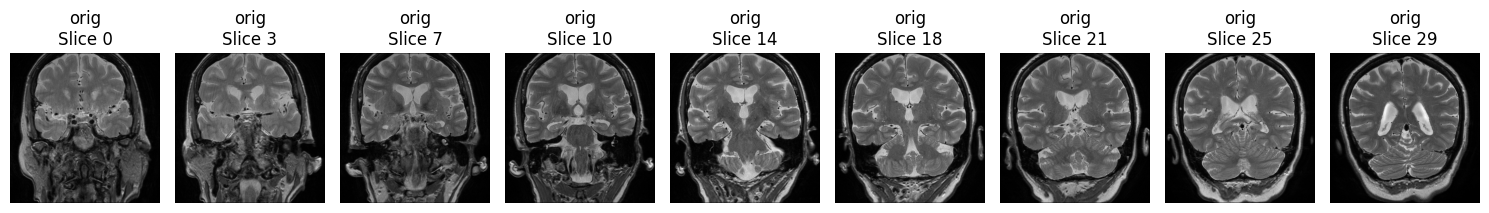

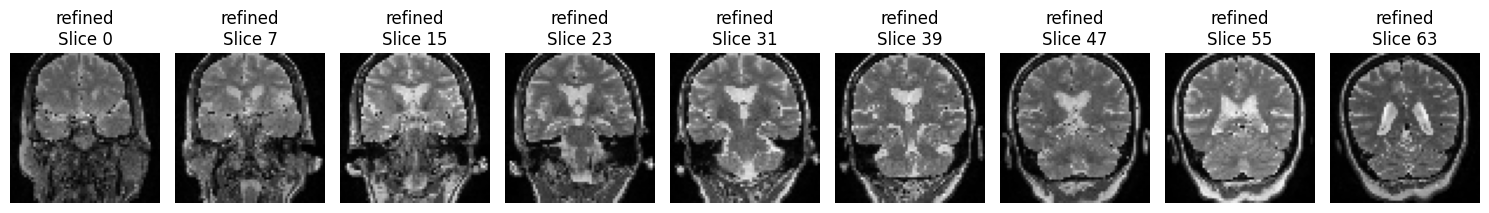

In [9]:
# visualize slices before and after preprocessing

show_slices(data_original, title="orig", axis=2, num_slices=9)
show_slices(data_resized, title="refined", axis=2, num_slices=9)

In [10]:
def show_slices_comparison(orig_vol, proc_vol, axis=2, num_slices=9):
    """Show equivalent slices from original and processed MRI volumes."""
    fig, axes = plt.subplots(2, num_slices, figsize=(16, 4))
    fig.suptitle("MRI Preprocessing Comparison: Original vs Normalized+Resized", fontsize=12, y=1.05)

    # compute normalized positions (0 to1) along chosen axis
    positions = np.linspace(0, 1, num_slices)

    for i, frac in enumerate(positions):
        # Match corresponding anatomical locations
        idx_orig = int(frac * (orig_vol.shape[axis] - 1))
        idx_proc = int(frac * (proc_vol.shape[axis] - 1))

        if axis == 0:
            orig_slice = orig_vol[idx_orig, :, :]
            proc_slice = proc_vol[idx_proc, :, :]
        elif axis == 1:
            orig_slice = orig_vol[:, idx_orig, :]
            proc_slice = proc_vol[:, idx_proc, :]
        else:
            orig_slice = orig_vol[:, :, idx_orig]
            proc_slice = proc_vol[:, :, idx_proc]

        # original slices
        axes[0, i].imshow(np.rot90(orig_slice), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].text(2, 10, f"z={idx_orig}", color="yellow", fontsize=8, weight="bold")

        # processed slices
        axes[1, i].imshow(np.rot90(proc_slice), cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].text(2, 10, f"z={idx_proc}", color="yellow", fontsize=8, weight="bold")

    axes[0, 0].set_ylabel("Original", fontsize=10, rotation=0, labelpad=30, va='center')
    axes[1, 0].set_ylabel("Processed", fontsize=10, rotation=0, labelpad=30, va='center')

    plt.subplots_adjust(top=0.85, wspace=0.02, hspace=0.05)
    plt.show()

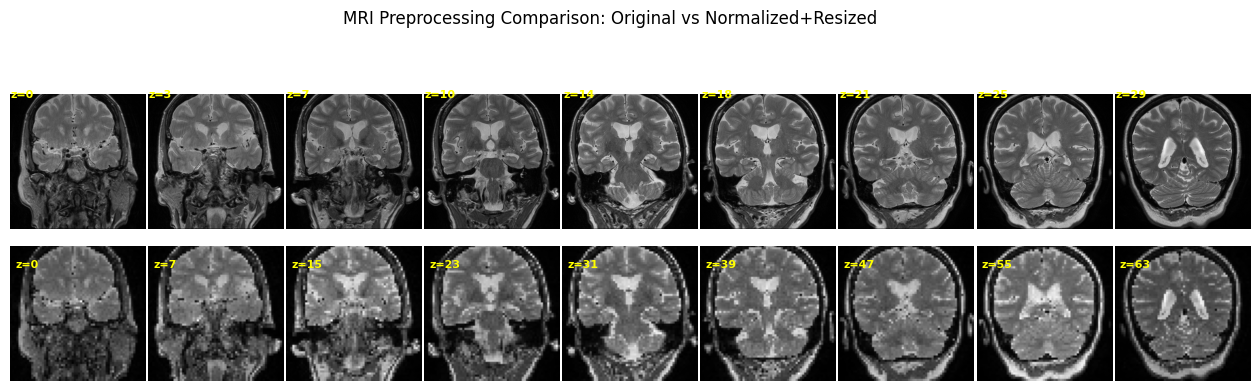

In [11]:
show_slices_comparison(data_original, data_resized, axis=2, num_slices=9)

**Build the preprocessing pipeline for all the MRI scans**

In [12]:
output_dir = Path(r"D:\projects\research\Preprocessed_NPY_64")
output_csv = Path(r"D:\projects\research\preprocessed_metadata_64.csv")

target_shape = (64, 64, 64)

In [13]:
def main():
    print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # read metadata
    mri_df = pd.read_csv(csv_path)
    print(f"Loaded {len(mri_df)} rows from metadata.")

    # create a new column for NIfTI paths based on Subject IDs
    mri_df['nifti_path'] = mri_df['Subject'].apply(lambda s: str(nifti_root / s / f"{s}.nii.gz"))

    # filter to rows where the nifti file exists
    mri_df = mri_df[mri_df['nifti_path'].apply(lambda p: Path(p).exists())]
    print(f"matched {len(mri_df)} MRI scans with NIfTI files")

    records = []

    for _, row in tqdm(mri_df.iterrows(), total=len(mri_df)):
        subject_id = row["Subject"]
        group = row["Group"]
        nifti_path = Path(row["nifti_path"])

        try:
            data = load_nifti_image(nifti_path)
            data = normalize_image(data)
            data = resize_image(data, target_shape)

            # save npy
            output_path = output_dir / f"{subject_id}.npy"
            np.save(output_path, data)

            # record metadata
            records.append({
                "subject": subject_id,
                "path": str(output_path),
                "label": group,
                "sex": row.get("Sex", None),
                "age": row.get("Age", None),
                "visit": row.get("Visit", None),
                "nifti_source": str(nifti_path)
            })

        except Exception as e:
            print(f"Error processing {nifti_path.name}: {e}")

    # save new csv
    new_df = pd.DataFrame(records)
    new_df.to_csv(output_csv, index=False)

    print(f"\nPreprocessing complete!")
    print(f"Saved {len(new_df)} preprocessed MRIs to {output_dir}")
    print(f"Metadata CSV saved to: {output_csv}")

In [14]:
# run 
if __name__ == "__main__":
    main()

Using device: NVIDIA GeForce RTX 5090 Laptop GPU
Loaded 637 rows from metadata.
matched 636 MRI scans with NIfTI files


100%|██████████| 636/636 [01:23<00:00,  7.60it/s]


Preprocessing complete!
Saved 636 preprocessed MRIs to D:\projects\research\Preprocessed_NPY_64
Metadata CSV saved to: D:\projects\research\preprocessed_metadata_64.csv
